# Gentle introduction to social networks in Python

### Prof. Jose Manuel MAGALLANES.
* Professor at Pontificia Universidad Católica del Peru
* Senior Data Scientist at eScience Institute, University of Washington

_______


## CONTENTS:

### 1. Network from dataframes


These data frames have been previously prepared, based on the data from [50 influential people in Seattle tech to follow on Twitter](https://www.builtinseattle.com/2018/08/06/50-seattle-tech-twitter-accounts-to-follow). The file can be seen [here](https://docs.google.com/spreadsheets/d/e/2PACX-1vTpWvtfphnO9eRYwmEyxVAxxo1KEsdpK6sK6q5uhJn5x2QtB-eGiso8ibpF16NaHAers4wDIHkvBo64/pubhtml), and includes 3 sheets:

* Network as two columns representing edges.
* Network as adjacency matrix.
* Attributes of the Network nodes.

In [112]:
fileLink='https://github.com/eScience-UW/gentleIntro_networks/raw/main/data/seattleTop.xlsx'

import pandas as pd

edges=pd.read_excel(io=fileLink,sheet_name="edges")
adjacency=pd.read_excel(io=fileLink,sheet_name="adjacency",index_col=0)# index_col!
attributes=pd.read_excel(io=fileLink,sheet_name="attributes")

Use the previous dataframes to create the network:

* From the edges:

In [113]:
import networkx as net # package needed

EliteNet =net.from_pandas_edgelist(edges)

In [114]:
EliteNet,len(EliteNet.nodes),len(EliteNet.edges)

(<networkx.classes.graph.Graph at 0x165ac3f10>, 46, 393)

* From the adjacency:

In [115]:
EliteNet = net.Graph(adjacency)

In [116]:
EliteNet,len(EliteNet.nodes),len(EliteNet.edges)

(<networkx.classes.graph.Graph at 0x165cce810>, 46, 393)

### 2. Adding Node attributes

Attributes are added using dictionaries _{node_name:attribute_value}_:

In [117]:
# create dictionaries
dictAttribute_male=dict(zip(attributes.name,attributes.male))
dictAttribute_followers=dict(zip(attributes.name,attributes.followers))

In [118]:
# set attribute with the dictionaries
net.set_node_attributes(EliteNet, dictAttribute_male,'male')
net.set_node_attributes(EliteNet, dictAttribute_followers,'followers')

In [119]:
## see them
EliteNet.nodes(data=True)

NodeDataView({'rachelerman': {'male': 0, 'followers': 7139}, 'mattmcilwain': {'male': 1, 'followers': 2804}, 'DaveParkerSEA': {'male': 1, 'followers': 3328}, 'toddbishop': {'male': 1, 'followers': 24500}, 'ashannstew': {'male': 0, 'followers': 3382}, 'LeslieFeinzaig': {'male': 0, 'followers': 15900}, 'akipman': {'male': 1, 'followers': 29500}, 'matt_oppy': {'male': 1, 'followers': 4847}, 'gilbert': {'male': 1, 'followers': 25800}, 'juliesandler': {'male': 0, 'followers': 7031}, 'BradSmi': {'male': 1, 'followers': 96300}, 'crashdev': {'male': 0, 'followers': 8773}, 'ShaunaCausey': {'male': 0, 'followers': 47400}, 'john_gabbert': {'male': 1, 'followers': 2482}, 'moniguzman': {'male': 0, 'followers': 29000}, 'mattmday': {'male': 1, 'followers': 5750}, 'Rich_Barton': {'male': 1, 'followers': 31300}, 'daryn': {'male': 1, 'followers': 2378}, 'lovelletters': {'male': 0, 'followers': 4553}, 'etzioni': {'male': 1, 'followers': 27400}, 'MissDestructo': {'male': 0, 'followers': 41800}, 'heatherre

In [120]:
maleValues=net.get_node_attributes(EliteNet,'male').values()
colors_for_nodes=['green' if attr==1 else 'red' for attr in maleValues]

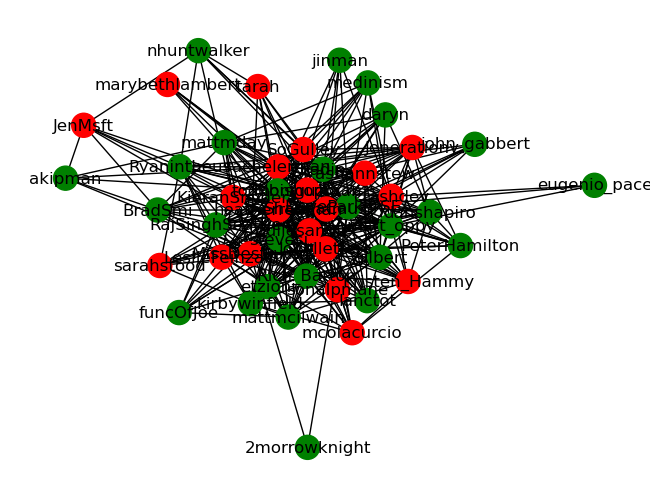

In [121]:
net.draw(EliteNet,
        with_labels=True,
        node_color=colors_for_nodes)

## 3. Exploring the Network

* Connectedness: A network is  “connected” if there exists a _path_ between any pair of nodes (undirected networks).

In [122]:
net.is_connected(EliteNet)

True

* Density: from 0 to 1, where 1 makes it a ‘complete’ network: there is a link between every pair of nodes.

In [123]:
net.density(EliteNet) 

0.37971014492753624

* Diameter: When two vertices are connected, one can reach the other using multiple egdes. The geodesic is the shorthest path between two connected vertices. Then, the diameter, is the maximum geodesic in a network.

In [124]:
net.diameter(EliteNet)

3

* Transitivity: How probable is that two nodes with a common connection, are also connected.

In [125]:
net.transitivity(EliteNet)

0.5504252733900364

* Assortativity: it is a measure to see if nodes are connecting to other nodes similar to themselves. Closer to 1 means higher assortativity, closer to -1 diassortativity; while 0 is no assortativity.

a.  Degree assortativity: tendency for highly connected nodes to be connected among themselves.

In [126]:
net.degree_assortativity_coefficient(EliteNet)

-0.2541114236973634

b.  Categorical assortativity: tendency for nodes with other nodes sharing the same category.

In [127]:
net.attribute_assortativity_coefficient(EliteNet,'male')

0.043102108480546866

c. Assortativity (numerical): 

In [128]:
net.attribute_assortativity_coefficient(EliteNet,'followers')

-0.02871700940804263

## 4. Exploration of Network nodes

* Centrality: Identify importance of a node based on the role played in the network structure

    - The eigenvector of a vertex will tell you how well connected is a vertex; that is, vertices with the highest values are considered the most influential as they are connected to vertices that are also well connected.

    - The closeness of a vertex will tell you how close is a vertex to every other vertex. A vertex with high closeness can share information faster than the rest.

    - The betweeness of a vertex will tell you how critical is a vertex to connect vertex that are not connected directly.

In [129]:
# Computing centrality measures:
eigen=net.eigenvector_centrality(EliteNet)  
clos=net.closeness_centrality(EliteNet)
betw=net.betweenness_centrality(EliteNet,normalized=True)

In [130]:
# the dataframe of centralities
DFCentrality=pd.DataFrame(dict(Eigenvector = eigen,
                               Closeness = clos,
                               Betweenness = betw)) 

In [131]:
DFCentrality.reset_index(drop=False,names='person',inplace=True)
DFCentrality

,person,Eigenvector,Closeness,Betweenness
0,rachelerman,0.216208,0.750000,0.038210
1,mattmcilwain,0.129373,0.600000,0.004696
2,DaveParkerSEA,0.244652,0.833333,0.098119
3,toddbishop,0.267254,0.918367,0.111044
4,ashannstew,0.155090,0.625000,0.004576
5,LeslieFeinzaig,0.157292,0.625000,0.003989
6,akipman,0.042444,0.529412,0.000937
7,matt_oppy,0.199399,0.703125,0.025517
8,gilbert,0.149723,0.625000,0.005692
9,juliesandler,0.229808,0.762712,0.030922


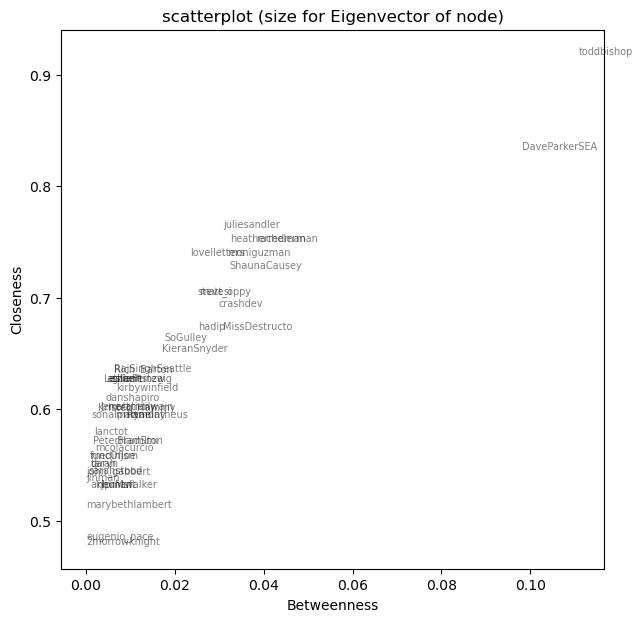

In [132]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(DFCentrality.Betweenness, DFCentrality.Closeness,s=(DFCentrality.Eigenvector+1)**10, alpha=0)

valsForAnnotate=zip(DFCentrality['person'],DFCentrality['Betweenness'],DFCentrality['Closeness'])

for name,coordX,coordY in valsForAnnotate:
    ax.annotate(name, (coordX,coordY),alpha=0.5,size=7)
    
plt.title("scatterplot (size for Eigenvector of node)")
plt.xlabel("Betweenness")
plt.ylabel("Closeness")
plt.show()

The previous results tells us thet two people are salient:

In [223]:
# Determine the hub name:
HubNodes=DFCentrality.nlargest(2, 'Eigenvector')['person']

HubNodes

3       toddbishop
2    DaveParkerSEA
Name: person, dtype: object

In [224]:
labelsHubs = {}    
for node in EliteNet.nodes():
    if node in HubNodes.to_list():
        #set the node name as the key and the label as its value 
        labelsHubs[node] = node
        
labelsHubs

{'DaveParkerSEA': 'DaveParkerSEA', 'toddbishop': 'toddbishop'}

In [225]:
EliteNet_nonHub=EliteNet.copy()
EliteNet_nonHub.remove_nodes_from(HubNodes)

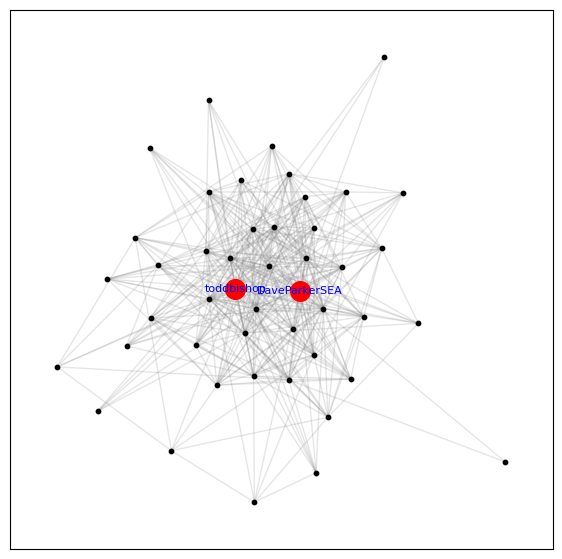

In [229]:
# prepare to plot:
fig, ax = plt.subplots(figsize=(7,7))

## positions of the nodes
pos=net.spring_layout(EliteNet)

#edges
net.draw_networkx_edges(EliteNet,pos,edge_color='grey',alpha=0.2)
# non hubs
net.draw_networkx_nodes(EliteNet_nonHub,pos,node_size=10,node_color='k')
# make the hub salient
net.draw_networkx_nodes(EliteNet,pos,nodelist=HubNodes.to_list(),node_size=200,node_color='r')
# label the hubs
net.draw_networkx_labels(EliteNet,pos,labels,font_size=8,font_color='blue')

plt.show()

In [80]:
list(net.articulation_points(EliteNet))

[]

In [73]:
len(net.minimum_edge_cut(EliteNet))

2

In [40]:
net.minimum_edge_cut(EliteNet)

{('DaveParkerSEA', '2morrowknight'), ('MissDestructo', '2morrowknight')}

In [26]:
len(list(net.articulation_points(EliteNet)))

0

In [27]:
len([a for a in net.enumerate_all_cliques(EliteNet)])

16724

In [28]:
net.graph_number_of_cliques(EliteNet)

221

In [29]:
net.graph_clique_number(EliteNet)

10

In [30]:
#pip install python-louvain

In [31]:
Y

NameError: name 'Y' is not defined

In [37]:
net.community.louvain_communities(EliteNet, seed=123)

[{'KieranSnyder',
  'Kristen_Hammy',
  'RajSinghSeattle',
  'Rich_Barton',
  'etzioni',
  'funcOfJoe',
  'gilbert',
  'juliesandler',
  'matt_oppy',
  'mattmcilwain'},
 {'Jenerationy',
  'PeterHamilton',
  'ShaunaCausey',
  'danshapiro',
  'daryn',
  'john_gabbert',
  'marybethlambert',
  'moniguzman',
  'rachelerman'},
 {'2morrowknight',
  'BradSmi',
  'JenMsft',
  'MissDestructo',
  'akipman',
  'mattmday',
  'toddbishop'},
 {'DaveParkerSEA',
  'SoGulley',
  'ashannstew',
  'crashdev',
  'eugenio_pace',
  'hadip',
  'jinman',
  'lanctot',
  'medinism',
  'nhuntwalker',
  'sonalpmane',
  'stevesi',
  'tarah'},
 {'LeslieFeinzaig',
  'Ryanintheus',
  'heatherredman',
  'kirbywinfield',
  'lovelletters',
  'mcolacurcio',
  'sarahstood'}]